In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from utils import sparse_accuracy_ignoring_last_label, sparse_crossentropy_ignoring_last_label, Jaccard
from data_scripts.data_loader import DataLoader
from utils import plot_prediction
from model import Deeplabv3
from tensorflow.keras.metrics import Accuracy, MeanIoU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:

BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "data")
PASCAL_ROOT = os.path.join(DATA_DIR, "VOCdevkit", "VOC2012")
IMGS_PATH = os.path.join(PASCAL_ROOT, "JPEGImages")

SEED = np.random.randint(0, 1000)
IMG_SIZE = (512, 512)
BATCH_SIZE = 1
BUFFER_SIZE = 1000
EPOCHS = 30
CLASSES = 21
RESHAPE_MASKS = True

In [13]:

#train_generator = SegmentationGenerator(root_folder=PASCAL_ROOT, mode="train", n_classes=21, resize_shape=IMG_SIZE, seed=SEED)
dataloader_train = DataLoader(
    root_folder=PASCAL_ROOT,
    mode="train",
    image_size=IMG_SIZE,
    channels=(3, 1),
    crop_percent=0.1,
    augment=True,
    compose=False,
    seed=SEED, 
    reshape_masks=RESHAPE_MASKS)

train_generator = dataloader_train.data_batch(batch_size=BATCH_SIZE, shuffle=True)

dataloader_val = DataLoader(
    root_folder=PASCAL_ROOT, 
    mode="val", 
    image_size=IMG_SIZE, 
    channels=(3, 1), 
    augment=False, 
    compose=False, 
    seed=SEED, 
    reshape_masks=RESHAPE_MASKS)
    
val_generator = dataloader_val.data_batch(batch_size=BATCH_SIZE, shuffle=True)


In [14]:
model = Deeplabv3(
    input_shape=(512, 512, 3), 
    classes=CLASSES, 
    OS=16, 
    activation=None, 
    reshape_outputs=RESHAPE_MASKS)

In [15]:
for images, masks in train_generator.take(2):
    sample_image, sample_mask = images[0], masks[0]
    if RESHAPE_MASKS:
        sample_mask = np.reshape(sample_mask, (*IMG_SIZE, 1))
    #plot_prediction([sample_image, sample_mask])

def create_mask(pred_mask: tf.Tensor) -> tf.Tensor:
    # pred_mask -> [IMG_SIZE, SIZE, N_CLASS]
    # 1 prediction for each class 
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1) # add 1 dim for plotting
    return pred_mask


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        prediction = model.predict(sample_image)
        
        if RESHAPE_MASKS:
            prediction = tf.reshape(prediction, (*IMG_SIZE, CLASSES))

        plot_prediction([sample_image, sample_mask, create_mask(prediction)], only_prediction=False, show_overlay=False)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

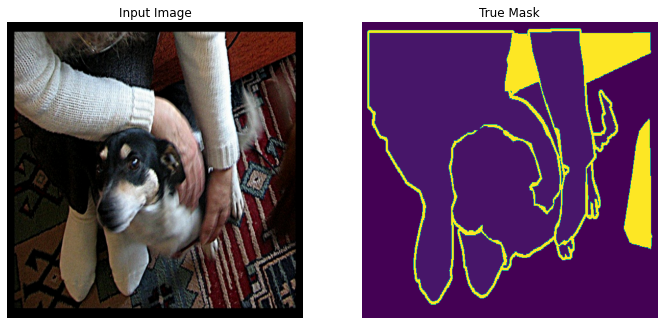

{0: 103038, 12: 32121, 15: 92208, 255: 34777}


In [16]:
plot_prediction([sample_image, sample_mask], only_prediction=False, show_overlay=False)
values, count = np.unique(sample_mask, return_counts=True)
print(dict(zip(values, count)))

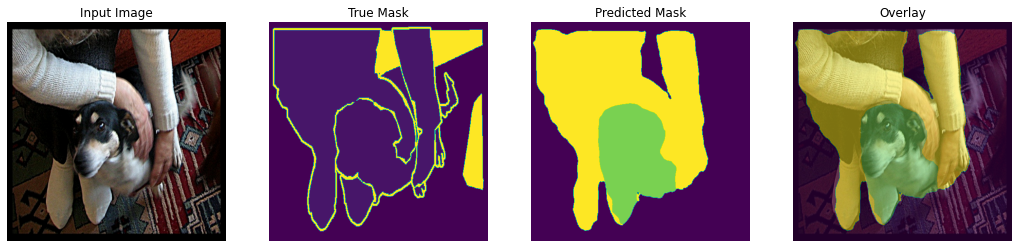

{0: 129939, 12: 34587, 15: 97618}


In [17]:
prediction = model.predict(sample_image[tf.newaxis, ...])
prediction = tf.reshape(prediction, (*IMG_SIZE, CLASSES))
mask = create_mask(prediction)
plot_prediction([sample_image, sample_mask, mask], only_prediction=False, show_overlay=True)
values, count = np.unique(mask, return_counts=True)
print(dict(zip(values, count)))

In [8]:
losses = sparse_crossentropy_ignoring_last_label
metrics = [Jaccard, sparse_accuracy_ignoring_last_label]
optimizer=Adam(learning_rate=1e-5, epsilon=1e-8, decay=1e-6)
#losses = SparseCategoricalCrossentropy(from_logits=True)
#metrics = "accuracy"

model.compile(optimizer=optimizer, sample_weight_mode="temporal",
              loss=losses, metrics=metrics, run_eagerly=True)


EPOCHS = 30

callbacks = [
    DisplayCallback(),
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=3, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

# model_history = model.fit(train_generator, epochs=EPOCHS,
#                           validation_data=val_generator,
#                           callbacks=callbacks)